In [6]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
#remove constant columns (std = 0)
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [8]:
# remove duplicated columns
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)


In [9]:
# split data into train and test
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)
print(X_train.shape, X_test.shape, test.shape)

(60816, 306) (15204, 306) (75818, 306)


In [10]:
# Feature selection
clf = RandomForestClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)

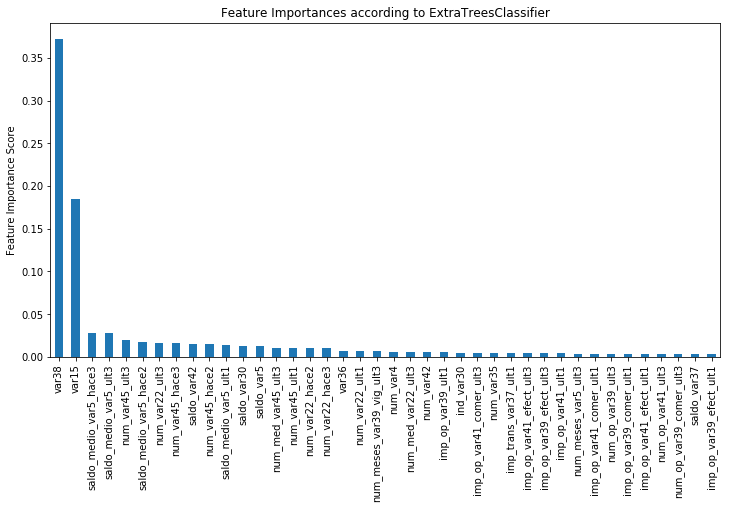

In [11]:
# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

In [12]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

In [13]:
print(X_train.shape, X_test.shape, test.shape)

(60816, 40) (15204, 40) (75818, 40)


In [14]:
# Train Model
# classifier from xgboost
m2_xgb = RandomForestClassifier(n_estimators=500, max_depth=5)
m2_xgb.fit(X_train, y_train)

# calculate the auc score
print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))
              
## # Submission
probs = m2_xgb.predict_proba(test)

submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission.to_csv("submission.csv", index=False)


Roc AUC:  0.804474647481


In [15]:
submission.head()

,ID,TARGET
0,2,0.033183
1,5,0.033652
2,6,0.010838
3,7,0.043551
4,9,0.011147
